In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
import pickle
from google.colab import files

In [4]:
uploaded = files.upload()

Saving cifar-10-python.tar.gz to cifar-10-python.tar.gz


In [6]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

100%|██████████| 170M/170M [00:01<00:00, 92.7MB/s]


In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 128 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.fc_dec(z).view(x.size(0), 128, 4, 4)
        x = self.decoder(x)
        return x, mu, logvar

In [8]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [9]:
epochs = 20

for epoch in range(epochs):
    total_loss = 0
    for images, _ in trainloader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(trainloader.dataset):.4f}")

Epoch [1/20], Loss: 330.1781
Epoch [2/20], Loss: 218.8848
Epoch [3/20], Loss: 205.1507
Epoch [4/20], Loss: 198.6991
Epoch [5/20], Loss: 195.3734
Epoch [6/20], Loss: 193.3658
Epoch [7/20], Loss: 191.6354
Epoch [8/20], Loss: 190.2680
Epoch [9/20], Loss: 189.3998
Epoch [10/20], Loss: 188.6068
Epoch [11/20], Loss: 187.7903
Epoch [12/20], Loss: 187.2161
Epoch [13/20], Loss: 186.7015
Epoch [14/20], Loss: 186.2193
Epoch [15/20], Loss: 185.9571
Epoch [16/20], Loss: 185.5708
Epoch [17/20], Loss: 185.1883
Epoch [18/20], Loss: 184.8457
Epoch [19/20], Loss: 184.6726
Epoch [20/20], Loss: 184.3528


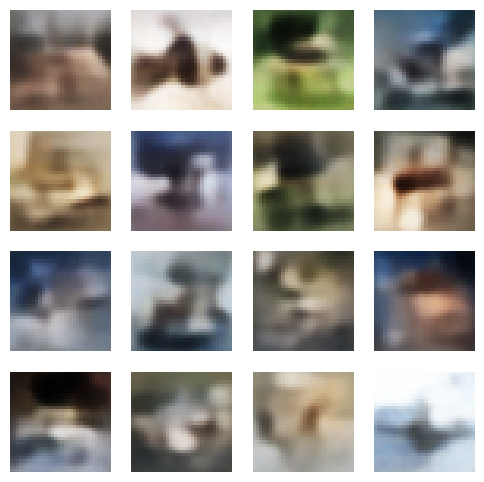

In [10]:
vae.eval()
with torch.no_grad():
    z = torch.randn(16, 128).to(device)
    samples = vae.decoder(vae.fc_dec(z).view(z.size(0), 128, 4, 4)).cpu()
    samples = (samples + 1) / 2

fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axs.flat):
    ax.imshow(samples[i].permute(1, 2, 0).numpy())
    ax.axis('off')

plt.show()

Task 3

Part 1

In [6]:
import numpy as np
import pandas as pd

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def scaled_dot_product_attention(Q, K, V):
    """
    Q, K, V: numpy arrays of shape (batch, seq_len, d_k)
    Returns:
      output: attention output
      weights: attention weights
    """
    d_k = Q.shape[-1]
    scores = np.matmul(Q, K.transpose(0, 2, 1)) / np.sqrt(d_k)
    weights = softmax(scores)
    output = np.matmul(weights, V)
    return output, weights

Q = np.array([[[1, 0, 1],
               [0, 1, 0]]])
K = np.array([[[1, 0, 1],
               [0, 1, 0]]])
V = np.array([[[1, 2],
               [3, 4]]])

output, weights = scaled_dot_product_attention(Q, K, V)
print("Output:\n", output)
print("Attention Weights:\n", pd.DataFrame(weights[0]))

Output:
 [[[1.47926312 2.47926312]
  [2.28091495 3.28091495]]]
Attention Weights:
           0         1
0  0.760368  0.239632
1  0.359543  0.640457


Part 2

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import math

def scaled_dot_product_attention_torch(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    attn = F.softmax(scores, dim=-1)
    output = torch.matmul(attn, V)
    return output, attn

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hidden_dim, num_layers=1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hidden_dim, num_layers, bidirectional=True)
        self.fc = nn.Linear(enc_hidden_dim * 2, enc_hidden_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        outputs_transposed = outputs.transpose(0, 1)
        attn_output, attn_weights = scaled_dot_product_attention_torch(outputs_transposed,
                                                                       outputs_transposed,
                                                                       outputs_transposed)
        outputs_combined = outputs_transposed + attn_output
        outputs_reduced = torch.tanh(self.fc(outputs_combined))
        outputs_reduced = outputs_reduced.transpose(0, 1)
        return outputs_reduced, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, dec_hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, dec_hidden_dim, num_layers)
        self.fc_out = nn.Linear(dec_hidden_dim, output_dim)

    def forward(self, input, hidden):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        dec_hidden = hidden[:self.decoder.rnn.num_layers]
        input = trg[0, :]

        for t in range(1, trg_len):
            output, dec_hidden = self.decoder(input, dec_hidden)
            outputs[t] = output
            teacher_force = np.random.rand() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

https://www.kaggle.com/datasets/shahadhamza/multi30k-dataset
unzip and upload the 4 files specified in code

In [3]:
from google.colab import files
uploaded = files.upload()
!unzip archive.zip

with open('train.en', encoding='utf-8') as f:
    train_en = f.readlines()
with open('train.fr', encoding='utf-8') as f:
    train_fr = f.readlines()

class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        for sentence in sentence_list:
            for word in sentence.split():
                word = word.lower()
                frequencies[word] = frequencies.get(word, 0) + 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized = text.split()
        return [self.stoi.get(token.lower(), self.stoi["<unk>"]) for token in tokenized]

src_vocab = Vocabulary(freq_threshold=2)
trg_vocab = Vocabulary(freq_threshold=2)
src_vocab.build_vocabulary(train_en)
trg_vocab.build_vocabulary(train_fr)

input_dim = len(src_vocab.stoi)
output_dim = len(trg_vocab.stoi)
print("Source Vocabulary Size:", input_dim)
print("Target Vocabulary Size:", output_dim)

Saving train.en to train.en
Saving train.fr to train.fr
Saving val.en to val.en
Saving val.fr to val.fr
unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.
Source Vocabulary Size: 7704
Target Vocabulary Size: 8512


In [8]:
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, src_file, trg_file, src_vocab, trg_vocab):
        with open(src_file, encoding='utf-8') as f:
            self.src_lines = f.readlines()
        with open(trg_file, encoding='utf-8') as f:
            self.trg_lines = f.readlines()
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, index):
        src_sentence = self.src_lines[index].strip()
        trg_sentence = self.trg_lines[index].strip()
        src_indices = [self.src_vocab.stoi["<sos>"]] + self.src_vocab.numericalize(src_sentence) + [self.src_vocab.stoi["<eos>"]]
        trg_indices = [self.trg_vocab.stoi["<sos>"]] + self.trg_vocab.numericalize(trg_sentence) + [self.trg_vocab.stoi["<eos>"]]
        return torch.tensor(src_indices), torch.tensor(trg_indices)

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=src_vocab.stoi["<pad>"])
    trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=trg_vocab.stoi["<pad>"])
    return src_batch, trg_batch

train_dataset = TranslationDataset('train.en', 'train.fr', src_vocab, trg_vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512

encoder = Encoder(input_dim, ENC_EMB_DIM, ENC_HID_DIM).to(device)
decoder = Decoder(output_dim, DEC_EMB_DIM, DEC_HID_DIM).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=src_vocab.stoi["<pad>"])

In [10]:
def train(model, dataloader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for src, trg in dataloader:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [12]:
N_EPOCHS = 5
CLIP = 1

for epoch in range(N_EPOCHS):
    loss = train(model, train_loader, optimizer, criterion, CLIP)
    print(f"Epoch {epoch+1}, Loss: {loss:.3f}")

Epoch 1, Loss: 4.306
Epoch 2, Loss: 3.177
Epoch 3, Loss: 2.618
Epoch 4, Loss: 2.210
Epoch 5, Loss: 1.877


In [15]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_bleu(model, dataloader):
    model.eval()
    bleu_scores = []
    smooth_fn = SmoothingFunction().method1
    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0.0)
            output_tokens = output.argmax(2)
            output_tokens = output_tokens.cpu().numpy().transpose()
            trg = trg.cpu().numpy().transpose()
            for pred_seq, true_seq in zip(output_tokens, trg):
                pred_words = [trg_vocab.itos[idx] for idx in pred_seq if idx not in [src_vocab.stoi["<pad>"], trg_vocab.stoi["<eos>"]]]
                true_words = [trg_vocab.itos[idx] for idx in true_seq if idx not in [src_vocab.stoi["<pad>"], trg_vocab.stoi["<eos>"]]]
                score = sentence_bleu([true_words], pred_words, smoothing_function=smooth_fn)
                bleu_scores.append(score)
    return np.mean(bleu_scores)

val_dataset = TranslationDataset('val.en', 'val.fr', src_vocab, trg_vocab)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
bleu_score = evaluate_bleu(model, val_loader)
print("Seq2Seq Model Validation BLEU Score with Smoothing:", bleu_score)

Seq2Seq Model Validation BLEU Score with Smoothing: 9.708875133625983e-05


In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linear_Q = nn.Linear(d_model, d_model)
        self.linear_K = nn.Linear(d_model, d_model)
        self.linear_V = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        Q = self.linear_Q(Q)
        K = self.linear_K(K)
        V = self.linear_V(V)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1,2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1,2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1,2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)
        context = context.transpose(1,2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        output = self.linear_out(context)
        return output, attn

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, _ = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model, num_layers, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout)
                                     for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, mask=None):
        x = self.embedding(src)
        x = self.pos_enc(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        self_attn_output, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        enc_dec_attn_output, _ = self.enc_dec_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(enc_dec_attn_output))
        ff_output = self.ff(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, output_dim, d_model, num_layers, num_heads, d_ff, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout)
                                     for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, tgt, enc_output, src_mask=None, tgt_mask=None):
        x = self.embedding(tgt)
        x = self.pos_enc(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        output = self.fc_out(x)
        return output

In [17]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = TransformerEncoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)
        self.decoder = TransformerDecoder(trg_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)

    def make_src_mask(self, src):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_tgt_mask(self, tgt):
        tgt_pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        tgt_len = tgt.size(1)
        tgt_sub_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
        tgt_mask = tgt_pad_mask & tgt_sub_mask
        return tgt_mask

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        enc_output = self.encoder(src, src_mask)
        output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        return output

d_model = 64
num_layers = 2
num_heads = 2
d_ff = 128

transformer_model = Transformer(input_dim, output_dim, d_model, num_layers, num_heads, d_ff, dropout=0.1).to(device)
optimizer_transformer = torch.optim.Adam(transformer_model.parameters(), lr=0.0005)
criterion_transformer = nn.CrossEntropyLoss(ignore_index=src_vocab.stoi["<pad>"])

def train_transformer(model, dataloader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for src, tgt in dataloader:
        src, tgt = src.transpose(0,1).to(device), tgt.transpose(0,1).to(device)
        optimizer.zero_grad()
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        output = model(src, tgt_input)
        output = output.reshape(-1, output.shape[-1])
        tgt_output = tgt_output.reshape(-1)
        loss = criterion(output, tgt_output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [18]:
N_EPOCHS_TRANSFORMER = 5
CLIP = 1
for epoch in range(N_EPOCHS_TRANSFORMER):
    loss = train_transformer(transformer_model, train_loader, optimizer_transformer, criterion_transformer, CLIP)
    print(f"Transformer Epoch {epoch+1}, Loss: {loss:.3f}")

Transformer Epoch 1, Loss: 4.831
Transformer Epoch 2, Loss: 3.488
Transformer Epoch 3, Loss: 3.035
Transformer Epoch 4, Loss: 2.737
Transformer Epoch 5, Loss: 2.506


In [21]:
def translate_sentence_transformer(model, sentence, src_vocab, trg_vocab, max_len=20):
    model.eval()
    tokens = [src_vocab.stoi["<sos>"]] + src_vocab.numericalize(sentence.strip()) + [src_vocab.stoi["<eos>"]]
    src_tensor = torch.tensor(tokens).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    enc_output = model.encoder(src_tensor, src_mask)
    tgt_indexes = [trg_vocab.stoi["<sos>"]]

    for i in range(max_len):
        tgt_tensor = torch.tensor(tgt_indexes).unsqueeze(0).to(device)
        tgt_mask = model.make_tgt_mask(tgt_tensor)
        output = model.decoder(tgt_tensor, enc_output, src_mask, tgt_mask)
        pred_token = output.argmax(2)[:,-1].item()
        tgt_indexes.append(pred_token)
        if pred_token == trg_vocab.stoi["<eos>"]:
            break
    translated_sentence = [trg_vocab.itos[idx] for idx in tgt_indexes]
    return translated_sentence

def evaluate_bleu_transformer(model, dataloader):
    model.eval()
    bleu_scores = []
    smooth_fn = SmoothingFunction().method1
    with torch.no_grad():
        for src, trg in dataloader:
            src = src.transpose(0,1).to(device)
            for i in range(src.size(0)):
                src_sentence = " ".join([src_vocab.itos[idx] for idx in src[i].cpu().numpy() if idx != src_vocab.stoi["<pad>"]])
                translation = translate_sentence_transformer(model, src_sentence, src_vocab, trg_vocab)
                translation = translation[1:-1]
                trg_sentence = " ".join([trg_vocab.itos[idx] for idx in trg[:, i].cpu().numpy() if idx not in [src_vocab.stoi["<pad>"], trg_vocab.stoi["<eos>"]]])
                score = sentence_bleu([trg_sentence.split()], translation, smoothing_function=smooth_fn)
                bleu_scores.append(score)
    return np.mean(bleu_scores)

bleu_score_transformer = evaluate_bleu_transformer(transformer_model, val_loader)
print("Transformer Model Validation BLEU Score:", bleu_score_transformer)

Transformer Model Validation BLEU Score: 0.2128885006739506
